# Exercise 4.3.9 

An Introduction to Random Matrix p263 (Anderson Guionnet Zeitouni) [cupbook]

# 1. Random matrix simulation

In [1]:
import numpy as np
from numpy.matlib import repmat
import plotly.graph_objs as go
import plotly.offline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
%matplotlib inline

In [2]:
def herm_matrix(dim, beta): #beta=1 pour real et 2 pour herm
    B = np.random.randn(dim, dim)
    B_tild = np.random.randn(dim, dim)
    diag = (2/(beta*dim))**0.5 * np.diag(np.diag(B))
    triu = (1/(beta*dim))**0.5 * (np.triu(B,1) + 1j*(beta-1)*np.triu(B_tild,1))
    H = np.zeros((dim,dim)) + diag + triu + triu.T
    return H

In [3]:
class DPP439_random_matrix:
    def __init__(self, n_traj, n_samples, tf, M):
        self.n_traj = n_traj
        self.n_samples = n_samples
        self.tf = tf
        self.dt = self.tf/n_samples
        self.dpp_matrix = [np.zeros((self.n_traj, self.n_traj))]
        self.initialisation(M)
        self.generate()
        self.eigen_values = np.zeros((self.n_samples, self.n_traj))
        self.diag()


    def initialisation(self, M):
        real_values = np.random.uniform(-0.0005, 0.0005, size=(self.n_traj, self.n_traj))
        im_values = np.random.uniform(-0.0005, 0.0005, size=(self.n_traj, self.n_traj))
        V_0 = np.matrix(real_values + 1j * im_values)
        self.dpp_matrix[0] = V_0
        return V_0

    def generate(self):
        for sample in range(self.n_samples-1):
            self.dpp_matrix.append(self.dpp_matrix[sample] + \
                herm_matrix(self.n_traj, beta=2)*(self.dt)**0.5 - \
                self.dpp_matrix[sample]*self.dt)

    def diag(self):
        for sample in range(self.n_samples-1):
            self.eigen_values[sample+1] = \
                sorted(np.real(np.linalg.eigvals(self.dpp_matrix[sample+1])), reverse=True)

    def plot(self):
        data=[]
        for traj in range(self.n_traj):
            traj_trace = go.Scatter(
                x=self.dt*np.array(range(self.n_samples)),
                y=(self.eigen_values.T)[traj],
                mode='lines')
            data.append(traj_trace)
        layout = go.Layout(showlegend=False)
        fig = go.Figure(data=data, layout=layout)
        plotly.offline.init_notebook_mode()
        plotly.offline.iplot(fig)

In [26]:
test_random_matrix = DPP439_random_matrix(100, 100, 1, 3)
#test_random_matrix.plot()

### With the rescaling

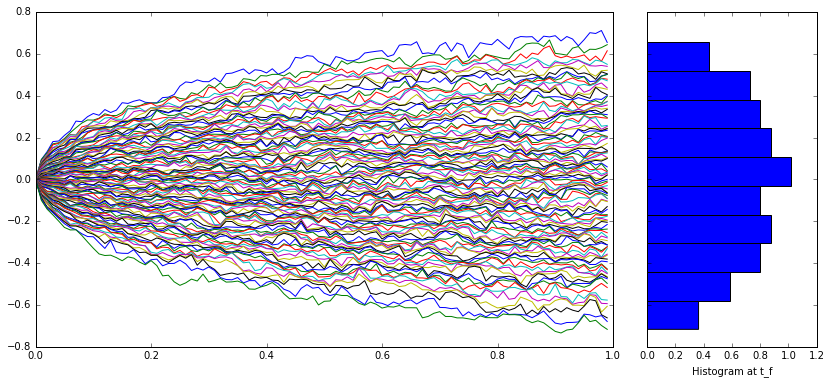

In [27]:
fig = plt.figure(1, figsize=(14, 6))
gs = GridSpec(1,4)

dpp_fig = fig.add_subplot(gs[0,0:3])
dpp_hist = fig.add_subplot(gs[0,3])


t = np.matlib.repmat(np.arange(0, test_random_matrix.tf, test_random_matrix.dt),test_random_matrix.n_traj,1)
dpp_fig.plot(t.T, test_random_matrix.eigen_values)

dpp_hist.hist(test_random_matrix.eigen_values[-1], bins=10, normed=True, orientation='horizontal')

plt.setp(dpp_hist.get_yticklabels(), visible=False)
dpp_hist.set_xlabel('Histogram at t_f')
dpp_hist.set_ylim(dpp_fig.get_ylim())
#x=np.linspace(-1,1)
#y=(0.8-x**2)**0.5
#dpp_hist.plot(y,x)
plt.show()

## 2. Stochastic differential equation simulation

In [6]:
class DPP439_eigen_values:
    def __init__(self, n_traj, n_samples, tf):
        self.n_traj = n_traj
        self.n_samples = n_samples
        self.tf=tf
        self.dt = tf/n_samples
        self.eigen_values = np.zeros((self.n_samples, self.n_traj))
        self.initialisation()
        self.generate()

    def initialisation(self):
        # real_values = np.random.uniform(-0.05, 0.05, size=(self.n_traj, self.n_traj))
        # im_values = np.random.uniform(-0.05, 0.05, size=(self.n_traj, self.n_traj))
        # V_0 = np.matrix(real_values + 1j * im_values)
        # self.eigen_values[0] = sorted(np.real(np.linalg.eigvals(V_0)), reverse=False)
        self.eigen_values[0] = np.linspace(1, 0.01, num=self.n_traj)
        # self.eigen_values[0][1]=self.eigen_values[0][2]+0.1
        #self.eigen_values[0]=np.zeros((1,self.n_traj))
        return self.eigen_values

    def generate(self):
        for sample in range(self.n_samples-1):
            
            for i in range(self.n_traj):

                lbda_i = self.eigen_values[sample][i]
                eigen_values_list = [lbda for lbda in list(self.eigen_values[sample]) if lbda != lbda_i]

                sum_term = sum ([ (1/(lbda_i - lbda_k)) for lbda_k in eigen_values_list ])
                # print("sumterm", sum_term)

                W = (self.dt)**(0.5) * np.random.randn()
                self.eigen_values[sample+1][i] = self.eigen_values[sample][i] + \
                                                W *(1/self.n_traj)**(0.5) + \
                                                 (1/self.n_traj)*sum_term * self.dt - \
                                                 self.eigen_values[sample][i] * self.dt
                # print("eigen:", self.eigen_values[sample+1][i])

            self.eigen_values[sample + 1] = sorted(self.eigen_values[sample + 1])

        return self.eigen_values

    def plot(self):
        data = []
        for traj in range(self.n_traj):
            traj_trace = go.Scatter(
                x=self.dt*np.array(range(self.n_samples)),
                y=self.eigen_values.T[traj],
                mode='lines')
            data.append(traj_trace)
        layout = go.Layout(showlegend=False)
        fig = go.Figure(data=data, layout=layout)
        plotly.offline.init_notebook_mode()
        plotly.offline.iplot(fig)

In [7]:
test_eigen_values = DPP439_eigen_values(30, 3000, 1)
test_eigen_values.plot()

ERROR: Line magic function `%plt.setp` not found.


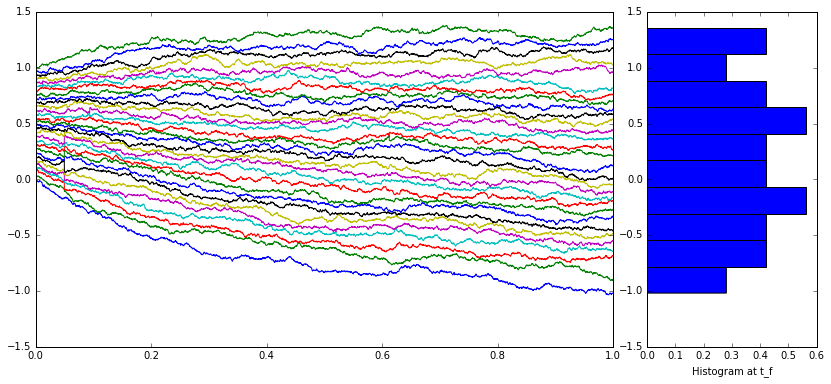

In [9]:
fig = plt.figure(1, figsize=(14, 6))
gs = GridSpec(1,4)

dpp_fig = fig.add_subplot(gs[0,0:3])
dpp_hist = fig.add_subplot(gs[0,3])


t = np.matlib.repmat(np.arange(0, test_eigen_values.tf, test_eigen_values.dt),test_eigen_values.n_traj,1)
dpp_fig.plot(t.T, test_eigen_values.eigen_values)

dpp_hist.hist(test_eigen_values.eigen_values[-1], bins=10, normed=True, orientation='horizontal')

plt.setp(dpp_hist.get_yticklabels(), visible=False)
dpp_hist.set_xlabel('Histogram at t_f')
dpp_hist.set_ylim(dpp_fig.get_ylim())

plt.show()

In [66]:
test=[1,4,1]
test=sorted(test)

In [67]:
test

[1, 1, 4]